In [ ]:
import os
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt

from PIL import Image
import cv2
import imageio
import random
from collections import Counter

from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score
from sklearn.utils import class_weight

In [ ]:
import tensorflow as tf
tf.random.set_seed(42)
import keras

from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Dropout, Dense, Flatten, MaxPooling2D, Conv2D
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.metrics import BinaryCrossentropy
from keras.callbacks import LearningRateScheduler

from keras.preprocessing.image import ImageDataGenerator

from keras.applications.resnet import ResNet50

## ResNet50

In [ ]:
image_generator = ImageDataGenerator(rescale=1./255)

train_folder = '/content/drive/MyDrive/Omdena_multimodal/forLucyOmdena/pneumonia_selected/train'
valid_folder = '/content/drive/MyDrive/Omdena_multimodal/forLucyOmdena/pneumonia_selected/valid'

TARGET_SIZE = (224, 224)
BATCH_SIZE = 16
IMAGE_SIZE = 224

train_generator = image_generator.flow_from_directory(train_folder,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=True,
                                                      class_mode='binary',
                                                      color_mode = 'rgb',
                                                      target_size=TARGET_SIZE,
                                                      seed=42)

valid_generator = image_generator.flow_from_directory(valid_folder,
                                                    target_size=TARGET_SIZE,
                                                    batch_size = BATCH_SIZE,
                                                    color_mode = 'rgb',
                                                    shuffle=False,
                                                    class_mode = 'binary',
                                                    seed=42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size

Found 949 images belonging to 2 classes.
Found 286 images belonging to 2 classes.


In [ ]:
train_classes = train_generator.classes
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.7579872204472844, 1: 1.4690402476780187}

In [ ]:
# create model
def ResNet50_Model():
    baseModel = ResNet50(weights='imagenet', include_top=False, input_tensor= tf.keras.layers.Input(shape=(224, 224, 3)))
    x = baseModel.output
    x = AveragePooling2D(pool_size=(2, 2))(x)
    x = Flatten(name="flatten")(x)
    x = Dense(512, activation="relu")(x)
    x = Dropout(0.3)(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=baseModel.input, outputs=x)
    # loop over all layers in the base model and freeze them so they will not be updated during the first training process
    for layer in baseModel.layers:
        layer.trainable = False
    return model

model = ResNet50_Model()

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
INIT_LR = 0.001
EPOCHS = 20


In [ ]:
# compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS),
              metrics = ['accuracy'])

In [ ]:
# train model
r = model.fit(train_generator,
                    steps_per_epoch = STEP_SIZE_TRAIN,
                    validation_data = valid_generator,
                    validation_steps = STEP_SIZE_VALID,
                    epochs = EPOCHS,
                    class_weight = class_weights)

Epoch 1/20
59/59 [==============================] - 12s 154ms/step - loss: 0.5211 - accuracy: 0.7738 - val_loss: 0.4938 - val_accuracy: 0.8051
Epoch 2/20
59/59 [==============================] - 6s 100ms/step - loss: 0.5176 - accuracy: 0.7728 - val_loss: 0.4934 - val_accuracy: 0.8125
Epoch 3/20
59/59 [==============================] - 7s 113ms/step - loss: 0.5128 - accuracy: 0.7814 - val_loss: 0.5918 - val_accuracy: 0.6691
Epoch 4/20
59/59 [==============================] - 7s 124ms/step - loss: 0.5210 - accuracy: 0.7556 - val_loss: 0.5150 - val_accuracy: 0.7647
Epoch 5/20
59/59 [==============================] - 7s 120ms/step - loss: 0.5163 - accuracy: 0.7653 - val_loss: 0.4905 - val_accuracy: 0.8162
Epoch 6/20
59/59 [==============================] - 7s 114ms/step - loss: 0.5138 - accuracy: 0.7567 - val_loss: 0.4847 - val_accuracy: 0.8162
Epoch 7/20
59/59 [==============================] - 6s 101ms/step - loss: 0.5195 - accuracy: 0.7546 - val_loss: 0.5207 - val_accuracy: 0.8199
Epoch

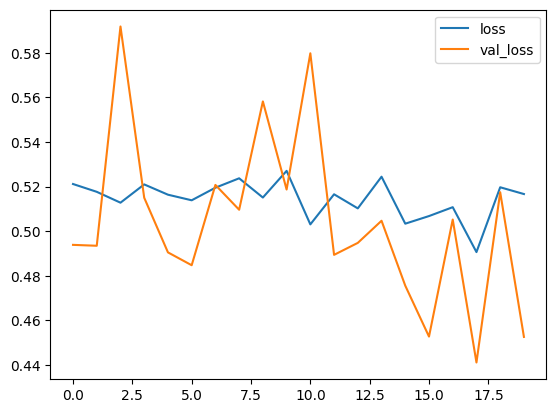

In [ ]:
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

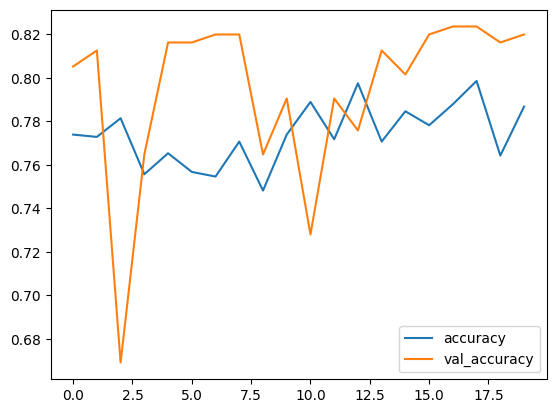

In [ ]:
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()

## Testing the model

In [ ]:
test_folder = '/content/drive/MyDrive/Omdena_multimodal/forLucyOmdena/pneumonia_selected/test'

In [ ]:
test_generator = image_generator.flow_from_directory(test_folder,
                                                    target_size=TARGET_SIZE,
                                                    batch_size = 1,
                                                    color_mode = 'rgb',
                                                    shuffle=False,
                                                    class_mode = 'binary')

Found 286 images belonging to 2 classes.


In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

preds = model.predict_generator(test_generator,steps = nb_samples)

<ipython-input-36-adfd4077dec3>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator,steps = nb_samples)


In [ ]:
y_pred = np.round(preds)

In [ ]:
np.max(y_pred)

1.0

In [ ]:
y_true = test_generator.classes

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[183,   3],
       [ 50,  50]])

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.8146853146853147


In [ ]:
precision = precision_score(y_true, y_pred)
print("Test Precision:", precision)

Test Precision: 0.9433962264150944


In [ ]:
recall = recall_score(y_true, y_pred)
print("Test Recall:", recall)

Test Recall: 0.5


In [ ]:
f1 = f1_score(y_true, y_pred)
print("f1 score:", f1)

f1 score: 0.6535947712418301
